<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HAC Data Preprocessing

### Import Libraries

In [1]:
# Import Libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Set up global settings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Files

In [2]:
# Data Collection
def setup_google_drive():
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)


def download_file(drive, file_id, file_name):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(file_name)


def collect_data():
    drive = setup_google_drive()

    # List of files and their IDs
    files_to_download = {
        'D_LABITEMS.csv': '1YsUqF-NkdLUL2hWRaxQgE7pyB1lGv4ox',
        'D_ICD_PROCEDURES.csv': '10nZG-naIdrVd1wj7JI5cwYDx4a8sp738',
        'D_ITEMS.csv': '11Jy050RqqIRPnsgbM6-YSRILyvIKRxJk',
        'D_ICD_DIAGNOSES.csv': '1d8oxIZy-UY1AflEgmYugfTFHKn9tiK_P',
        'PATIENTS.csv': '1JI_F9GBr7ul5c-c4C1x0xxcfOB3BOTxv',
        'PROCEDURES_ICD.csv': '1eWYJMBcujAlKohuDyl99obl9wZzaveu4',
        'ADMISSIONS.csv': '1zfjctJQU-FtY-EOoUh_f4_bSVrPOn0Kc',
        'DIAGNOSES_ICD.csv': '1O_5wyg0LHDnlKq8ULLyVG0hC862fqoJb',
        'LABEVENTS.csv': '1zAIm6nbkWrAtHNu06J34ygsPavYtpCjR',
        'all_features_df.csv':'1PdVBEoYMBtG9FP3Cscg5mEjJ8cwnx3Qc'
    }

    for file_name, file_id in files_to_download.items():
        download_file(drive, file_id, file_name)

    return {
        'd_labitems': pd.read_csv('D_LABITEMS.csv'),
        'd_icd_procedures': pd.read_csv('D_ICD_PROCEDURES.csv'),
        'd_icd_procedures' : pd.read_csv('D_ICD_PROCEDURES.csv'),
        'd_items' : pd.read_csv('D_ITEMS.csv'),
        'd_icd_diagnoses' : pd.read_csv('D_ICD_DIAGNOSES.csv'),
        'patients' : pd.read_csv('PATIENTS.csv'),
        'procedures_icd' : pd.read_csv('PROCEDURES_ICD.csv'),
        'admissions' : pd.read_csv('ADMISSIONS.csv'),
        'diagnoses_icd' : pd.read_csv('DIAGNOSES_ICD.csv'),
        'labevents' : pd.read_csv('LABEVENTS.csv', usecols=['HADM_ID', 'ITEMID', 'FLAG']),
        'all_features_df' : pd.read_csv('all_features_df.csv')

    }


### Create Functions for Data Preprocessing

In [3]:
# Data Cleaning
def add_admission_duration(admissions):
    admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
    admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
    admissions['admission_duration'] = admissions['DISCHTIME'] - admissions['ADMITTIME']
    return admissions

def merge_patients_admission(admissions, patients):
    return pd.merge(admissions, patients, on='SUBJECT_ID', how='left')

def calculate_and_set_age(admission_merged):
    # Convert columns to datetime format
    admission_merged['ADMITTIME'] = pd.to_datetime(admission_merged['ADMITTIME'])
    admission_merged['DOB'] = pd.to_datetime(admission_merged['DOB'])

    # Calculate age using the 'calculate_age' function
    admission_merged['AGE_AT_ADMISSION'] = admission_merged.apply(
        lambda row: calculate_age(row['ADMITTIME'], row['DOB']),
        axis=1
    )
    return admission_merged

def calculate_age(admit_time, dob):
    try:
        # Convert pandas timestamps to Python datetime objects
        admit_datetime = admit_time.to_pydatetime()
        dob_datetime = dob.to_pydatetime()

        # Calculate age
        age = int((admit_datetime - dob_datetime).days // 365.25)
        return age if age > 0 else np.nan  # Assign NaN for negative ages
    except OverflowError:
        return np.nan

def replace_invalid_ages(admission_merged):
    # Compute the median age
    median_age = admission_merged['AGE_AT_ADMISSION'].median()

    # Replace values greater than 100 with the median age
    admission_merged.loc[admission_merged['AGE_AT_ADMISSION'] > 130, 'AGE_AT_ADMISSION'] = median_age

    # Convert timedelta to days
    admission_merged['admission_duration_days'] = admission_merged['admission_duration'].dt.total_seconds() / (24 * 3600)

    return admission_merged

def merge_diagnosis_names(diagnoses_icd, d_icd_diagnoses):
    # Convert the ICD9_CODE columns in both DataFrames to string data type
    d_icd_diagnoses['ICD9_CODE'] = d_icd_diagnoses['ICD9_CODE'].astype(str)
    diagnoses_icd['ICD9_CODE'] = diagnoses_icd['ICD9_CODE'].astype(str)

    # Merge diagnosis with diagnosis_icd using a left merge
    diagnosis_merged = pd.merge(diagnoses_icd, d_icd_diagnoses, on='ICD9_CODE', how='left')

    return diagnosis_merged

def combine_procedures(d_icd_procedures):
    # Combine the descriptions for the same ICD code
    d_icd_procedures['SHORT_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['SHORT_TITLE'].transform(lambda x: ' | '.join(x))
    d_icd_procedures['LONG_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['LONG_TITLE'].transform(lambda x: ' | '.join(x))

    # Drop duplicated rows based on ICD9_CODE, keeping the first occurrence
    procedure_icd_cleaned = d_icd_procedures.drop_duplicates(subset='ICD9_CODE', keep='first')

    return procedure_icd_cleaned

def merge_procedure_names(procedures_icd, procedure_icd_cleaned):
    # Copy the DataFrame to avoid modifying the original data
    procedure_icd_cleaned = procedure_icd_cleaned.copy()

    # Convert the ICD9_CODE columns to string data type
    procedure_icd_cleaned['ICD9_CODE'] = procedure_icd_cleaned['ICD9_CODE'].astype(str)
    procedures_icd['ICD9_CODE'] = procedures_icd['ICD9_CODE'].astype(str)

    # Merge procedure with procedure_icd using a left merge
    procedure_merged = pd.merge(procedures_icd, procedure_icd_cleaned, on='ICD9_CODE', how='left')

    return procedure_merged

def merge_lab_events(labevents, d_labitems):
    # Merge lab_event with lab_item using a left merge
    lab_merged = pd.merge(labevents, d_labitems, on='ITEMID', how='left')

    return lab_merged

def clean_admission_merged(admission_merged):
    # Drop irrelevant columns
    columns_to_drop = ['ROW_ID_x', 'ROW_ID_y', 'DISCHARGE_LOCATION']
    admission_merged = admission_merged.drop(columns=columns_to_drop)

    return admission_merged

def clean_diagnosis_merged(diagnosis_merged):
    # Drop irrelevant columns
    columns_to_drop = ['ROW_ID_x', 'ROW_ID_y', 'SUBJECT_ID']
    diagnosis_merged = diagnosis_merged.drop(columns=columns_to_drop)

    return diagnosis_merged

def sample_balanced_dataset(diagnosis_merged, admission_merged, size=5000, use_all_data=False):
    # Extract unique HADM_IDs where the diagnosis is UTI (ICD9_CODE = '5990')
    uti_hadm_ids = diagnosis_merged[diagnosis_merged['ICD9_CODE'] == '5990']['HADM_ID'].unique()

    if use_all_data:
        sampled_uti_hadm_ids = uti_hadm_ids  # Use all the available HADM_IDs for UTI
    else:
        # Randomly sample 'size' number of unique HADM_IDs from UTI cases
        sampled_uti_hadm_ids = np.random.choice(uti_hadm_ids, size=size, replace=False)

    # Get unique HADM_IDs for non-UTI cases
    non_uti_hadm_ids = diagnosis_merged[diagnosis_merged['ICD9_CODE'] != '5990']['HADM_ID'].unique()

    if use_all_data:
        sampled_non_uti_hadm_ids = non_uti_hadm_ids  # Use all the available HADM_IDs for non-UTI
    else:
         # Randomly sample 'size' number of unique HADM_IDs from non-UTI cases
        sampled_non_uti_hadm_ids = np.random.choice(non_uti_hadm_ids, size=size, replace=False)

    # Filter rows from diagnosis_merged where HADM_ID is in sampled_uti_hadm_ids and ICD9_CODE is '5990'
    sampled_uti_diagnosis = diagnosis_merged[(diagnosis_merged['HADM_ID'].isin(sampled_uti_hadm_ids)) & (diagnosis_merged['ICD9_CODE'] == '5990')]

    # Drop duplicates based on HADM_ID and ICD9_CODE
    sampled_uti_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)

    # Filter rows from diagnosis_merged where HADM_ID is in sampled_non_uti_hadm_ids
    sampled_non_uti_diagnosis = diagnosis_merged[diagnosis_merged['HADM_ID'].isin(sampled_non_uti_hadm_ids)]

    # Combine UTI and non-UTI samples in both dataframes
    final_sampled_diagnosis = pd.concat([sampled_uti_diagnosis, sampled_non_uti_diagnosis]).reset_index(drop=True)

    # Combine sampled admission information
    sampled_uti_admission = admission_merged[admission_merged['HADM_ID'].isin(sampled_uti_hadm_ids)]
    sampled_non_uti_admission = admission_merged[admission_merged['HADM_ID'].isin(sampled_non_uti_hadm_ids)]
    final_sampled_admission = pd.concat([sampled_uti_admission, sampled_non_uti_admission]).reset_index(drop=True)

    return final_sampled_diagnosis, final_sampled_admission


def preprocess_diagnosis_admission(final_sampled_diagnosis, final_sampled_admission):
    # Filter the rows where the diagnosis is UTI (ICD9_CODE = '5990')
    final_sampled_diagnosis = final_sampled_diagnosis[final_sampled_diagnosis['ICD9_CODE'] == '5990']

    # Drop duplicate rows based on HADM_ID and ICD9_CODE
    final_sampled_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)

    # Add a column to indicate the presence of the diagnosis (UTI in this case)
    final_sampled_diagnosis['present'] = 1

    # Pivot the dataframe to make it wide-format. This sets HADM_ID as index and ICD9_CODEs as columns
    wide_diagnosis = final_sampled_diagnosis.pivot(index='HADM_ID', columns='ICD9_CODE', values='present').fillna(0).reset_index()

    # Merge with the sampled admission data
    admission_icd_merged = pd.merge(final_sampled_admission, wide_diagnosis, on='HADM_ID', how='left')

    # Identify the ICD9_CODE columns and fill NaN values with 0
    icd9_columns = wide_diagnosis.columns.difference(['HADM_ID'])
    admission_icd_merged[icd9_columns] = admission_icd_merged[icd9_columns].fillna(0)

    # Rename the '5990' column to 'uti' for easier interpretation
    admission_icd_merged = admission_icd_merged.rename(columns={'5990': 'uti'})

    ## For categorical variable, replace NaN with 'missing_value'.
    admission_icd_merged['LANGUAGE'].fillna('missing_value', inplace=True)
    admission_icd_merged['MARITAL_STATUS'].fillna('missing_value', inplace=True)

    # For the AGE_AT_ADMISSION column, replace NaN values with the median.
    median_age = admission_icd_merged['AGE_AT_ADMISSION'].median()
    admission_icd_merged['AGE_AT_ADMISSION'].fillna(median_age, inplace=True)

    # drop unwanted columns
    admission_icd_merged.drop(columns=['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME',
                                       'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'admission_duration',
                                       'INSURANCE', 'LANGUAGE', 'RELIGION',
                                       'HOSPITAL_EXPIRE_FLAG', 'EXPIRE_FLAG', 'MARITAL_STATUS',
                                       'admission_duration_days'], inplace=True)
    return admission_icd_merged

# Preprocess lab_merged
def preprocess_lab(lab_merged):
    lab_subset = lab_merged[["HADM_ID", "LABEL", "FLAG"]]
    lab_subset = lab_subset[lab_subset["FLAG"] == "abnormal"]
    lab_subset = lab_subset[["HADM_ID", "LABEL"]]
    lab_subset.columns = ["HADM_ID", "lab_flag"]

    lab_subset = lab_subset.drop_duplicates(subset=["HADM_ID", "lab_flag"]).copy()
    lab_subset['present'] = 1
    wide_lab = lab_subset.pivot(index='HADM_ID', columns='lab_flag', values='present')
    wide_lab = wide_lab.fillna(0).reset_index()

    lab_columns = wide_lab.columns.difference(['HADM_ID'])
    wide_lab[lab_columns] = wide_lab[lab_columns].fillna(0)

    return wide_lab

# TO CHECK: preprocess procedures with topic modelling
def preprocess_procedure2(procedure_merged, n_groups=40):
    # extract rows with nans as long title, will use for later
    proced_icd_nans = procedure_merged[procedure_merged['LONG_TITLE'].isnull()]
    # drop rows with nans as long title
    proced = procedure_merged[procedure_merged['LONG_TITLE'].notnull()]
    list_procedures = proced['LONG_TITLE'].unique()

    # topic modelling for dimensionality reduction
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(list_procedures)

    # LDA
    lda = LatentDirichletAllocation(n_components=n_groups, random_state=42)
    lda_fit = lda.fit_transform(X)

    topic_list = []
    for i in range(len(lda_fit)):
        topic_list.append(np.argmax(lda_fit[i]))

    # map the topic to the procedure
    topic_proced = pd.DataFrame({'topic':topic_list, 'procedure':list_procedures})
    proced['topic'] = proced['LONG_TITLE'].map(topic_proced.set_index('procedure')['topic'])

    # reduce the df down to only the columns we need
    proced_icd_topic = proced[['HADM_ID','topic']]
    proced_n = proced_icd_topic.pivot_table(index='HADM_ID', columns='topic', aggfunc=len, fill_value=0)
    proced_n.reset_index(inplace=True)

    # reconstruct the df with the nans
    proced_icd_nans2 = proced_icd_nans[['HADM_ID']]
    proced_icd_nans2['topic'] = n_groups
    proced_icd_nans2 = proced_icd_nans2.pivot_table(index='HADM_ID', columns='topic', aggfunc=len, fill_value=0)
    proced_icd_nans2.reset_index(inplace=True)

    # merge the two dfs
    proced_n = proced_n.merge(proced_icd_nans2, on='HADM_ID', how='outer')
    proced_n.fillna(0, inplace=True)
    proced_n = proced_n.astype(int)

    # add prefix to column names
    proced_n = proced_n.add_prefix('p_')
    proced_n.rename(columns={'p_HADM_ID':'HADM_ID'}, inplace=True)
    proced_n = proced_n.rename_axis(None, axis=1)
    return proced_n, lda, vectorizer

def proced_feature_names(df, lda, vectorizer):
    # just for checking
    feature_names = vectorizer.get_feature_names_out()
    n_top_words = 10
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[::-1][:n_top_words] # get the index, sort by highest of the top words for each topic
        top_words = [feature_names[i] for i in top_words_idx] # map the index to the word
        #print(f"Topic {topic_idx}:", top_words)

    topic = {
        'p_0': 'Procedure: Digestive and Diaphragm Procedures',
        'p_1': 'Procedure: Lung Biopsy and Intervention',
        'p_2': 'Procedure: Cardiac Repair and Hernia Procedures',
        'p_3': 'Procedure: Intestinal Stoma and Manipulation',
        'p_4': 'Procedure: Aspiration and Organ Repair',
        'p_5': 'Procedure: Head and Device Insertion',
        'p_6': 'Procedure: Surgical Suture and Repair',
        'p_7': 'Procedure: Bone Fracture and Fixation',
        'p_8': 'Procedure: Electrode and Vascular Implantation',
        'p_9': 'Procedure: Structural and Bone Biopsy',
        'p_10': 'Procedure: Intestinal Transfer and Surgery',
        'p_11': 'Procedure: Gastric Procedure and Vascular Revision',
        'p_12': 'Procedure: Tissue Reconstruction and Catheterization',
        'p_13': 'Procedure: Arterial Imaging and Debridement',
        'p_14': 'Procedure: Limb Exploration and Surgery',
        'p_15': 'Procedure: Hip and Soft Tissue Procedures',
        'p_16': 'Procedure: Diagnostic and Device Implantation',
        'p_17': 'Procedure: Closure and Chest Procedures',
        'p_18': 'Procedure: Thoracic and Peritoneal Interventions',
        'p_19': 'Procedure: Trachea and Abdominal Procedures',
        'p_20': 'Procedure: Endoscopic and Perineal Procedures',
        'p_21': 'Procedure: Pancreatic and Bronchial Interventions',
        'p_22': 'Procedure: Dilation and Urethral Procedures',
        'p_23': 'Procedure: Spinal and Abdominal Surgery',
        'p_24': 'Procedure: Catheterization and Ventilation Techniques',
        'p_25': 'Procedure: Joint Dislocation and Hand Surgery',
        'p_26': 'Procedure: Vessel Anastomosis and Resection',
        'p_27': 'Procedure: Lesion Excision and Soft Tissue Surgery',
        'p_28': 'Procedure: External Device and Eyelid Repair',
        'p_29': 'Procedure: Tendon and Obstetric Procedures',
        'p_30': 'Procedure: Cranial and Peripheral Interventions',
        'p_31': 'Procedure: Large Intestine and Bone Surgery',
        'p_32': 'Procedure: Plastic Surgery and Duct Procedures',
        'p_33': 'Procedure: Foreign Body Removal and Graft',
        'p_34': 'Procedure: Facial and Thoracic Surgery',
        'p_35': 'Procedure: Knee and Spinal Surgery',
        'p_36': 'Procedure: Contrast Imaging and Spleen Procedures',
        'p_37': 'Procedure: Injections and Therapeutic Procedures',
        'p_38': 'Procedure: Fibula and Sinus Procedures',
        'p_39': 'Procedure: Renal and Thyroid Interventions',
        'p_40': 'Procedure: Not Found'
        }

    df.rename(columns=topic, inplace=True)
    return df

def one_hot_encoding(df):
    return pd.get_dummies(df, columns=None, drop_first=False)

### Run the Main Pipeline

In [ ]:
# Main Pipeline
def main():
    # Collect data
    data = collect_data()

    # Perform Data Cleaning
    data['admissions'] = add_admission_duration(data['admissions'])
    admission_merged = merge_patients_admission(data['admissions'], data['patients'])
    admission_merged = calculate_and_set_age(admission_merged)
    admission_merged = replace_invalid_ages(admission_merged)
    diagnosis_merged = merge_diagnosis_names(data['diagnoses_icd'], data['d_icd_diagnoses'])
    procedure_icd_cleaned = combine_procedures(data['d_icd_procedures'])
    procedure_merged = merge_procedure_names(data['procedures_icd'], procedure_icd_cleaned)
    lab_merged = merge_lab_events(data['labevents'], data['d_labitems'])
    admission_merged = clean_admission_merged(admission_merged)
    diagnosis_merged = clean_diagnosis_merged(diagnosis_merged)

    # Sample dataset
    np.random.seed(123)
    final_sampled_diagnosis, final_sampled_admission = sample_balanced_dataset(diagnosis_merged, admission_merged, size=5000, use_all_data=False)

    # Preprocess diagnosis
    admission_icd_merged = preprocess_diagnosis_admission(final_sampled_diagnosis, final_sampled_admission)

    # Preprocess lab
    wide_lab = preprocess_lab(lab_merged)

    # Preprocess procedure
    df, lda, vectorizer = preprocess_procedure2(procedure_merged)
    wide_procedure = proced_feature_names(df, lda,  vectorizer)

    # Merge them into a final dataframe
    admission_icd_procedure_merged = pd.merge(admission_icd_merged, wide_procedure, on='HADM_ID', how='left')
    admission_icd_procedure_lab_merged = pd.merge(admission_icd_procedure_merged, wide_lab, on='HADM_ID', how='left')

    # Perform one-hot encoding
    encoded_df = pd.get_dummies(admission_icd_procedure_lab_merged, columns=None, drop_first=False)

    # Replace all NaN values with 0
    encoded_df.fillna(0, inplace=True)

    encoded_df.columns = encoded_df.columns.astype(str)
    encoded_df = encoded_df.drop(['SUBJECT_ID', 'HADM_ID','DIAGNOSIS_SEPSIS'], axis=1)

    return encoded_df

if __name__ == '__main__':
    result = main()

In [6]:
result

HAS_CHARTEVENTS_DATA  AGE_AT_ADMISSION  uti  \
0                        1              63.0  1.0   
1                        1              85.0  1.0   
2                        1              59.0  1.0   
3                        1              87.0  1.0   
4                        1              57.0  1.0   
...                    ...               ...  ...   
9995                     1              49.0  0.0   
9996                     1              69.0  0.0   
9997                     1              69.0  1.0   
9998                     0              47.0  0.0   
9999                     1              53.0  0.0   

      Procedure: Digestive and Diaphragm Procedures  \
0                                               1.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               1.0   
...                                             ...   
9995                                            0.0   
9996                                            1.0   
9997                                            0.0   
9998                                            0.0   
9999                                            2.0   

      Procedure: Lung Biopsy and Intervention  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
...                                       ...   
9995                                      1.0   
9996                                      0.0   
9997                                      0.0   
9998                                      0.0   
9999                                      0.0   

      Procedure: Cardiac Repair and Hernia Procedures  \
0                                                 0.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   
...                                               ...   
9995                                              0.0   
9996                                              0.0   
9997                                              0.0   
9998                                              0.0   
9999                                              0.0   

      Procedure: Intestinal Stoma and Manipulation  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   
...                                            ...   
9995                                           0.0   
9996                                           0.0   
9997                                           0.0   
9998                                           0.0   
9999                                           0.0   

      Procedure: Aspiration and Organ Repair  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
9995                                     0.0   
9996                                     0.0   
9997                                     0.0   
9998                                     0.0   
9999                                     0.0   

      Procedure: Head and Device Insertion  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                       

### Save all_features_df.csv

In [7]:
# all_features_df = result
# all_features_df.to_csv('all_features_df.csv', index=False)

### Random Forest

Using Random Forest Feature Importance Scores to Select Top Features for Model Training.

In Random Forest, feature importance for a variable is typically calculated as the total decrease in node impurity (usually measured by the Gini impurity or entropy) that is brought by that feature, averaged over all trees.

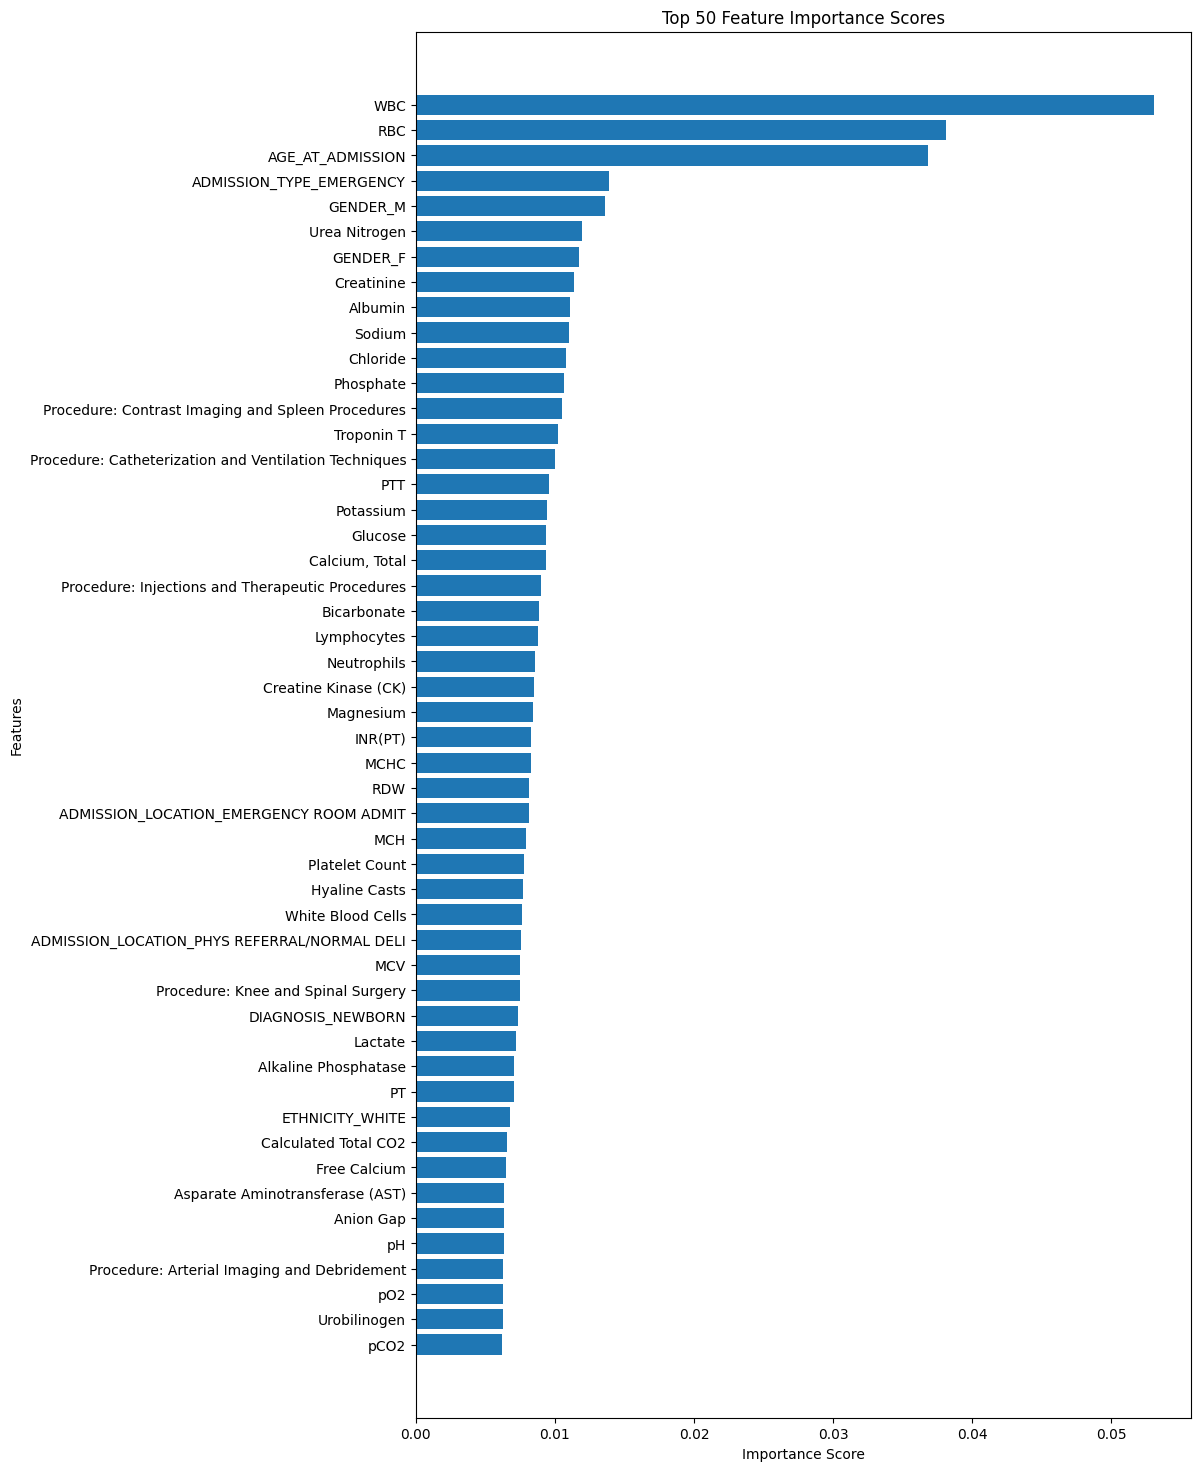

In [8]:
# Train Test Split
X = result.drop('uti', axis=1)
y = result['uti']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature Importance
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top 50 features
sorted_indices = np.argsort(importances)[-50:]

# Plot the top features
plt.figure(figsize=(10,18))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


In [9]:
# Get the indices of the top features
top_80_indices = np.argsort(importances)[-80:]

# Extract the names of the top features
top_80_features = features[top_80_indices]

# descending order (most important feature first)
top_80_features_list = list(top_80_features[::-1])

top_80_features_list

['WBC',
 'RBC',
 'AGE_AT_ADMISSION',
 'ADMISSION_TYPE_EMERGENCY',
 'GENDER_M',
 'Urea Nitrogen',
 'GENDER_F',
 'Creatinine',
 'Albumin',
 'Sodium',
 'Chloride',
 'Phosphate',
 'Procedure: Contrast Imaging and Spleen Procedures',
 'Troponin T',
 'Procedure: Catheterization and Ventilation Techniques',
 'PTT',
 'Potassium',
 'Glucose',
 'Calcium, Total',
 'Procedure: Injections and Therapeutic Procedures',
 'Bicarbonate',
 'Lymphocytes',
 'Neutrophils',
 'Creatine Kinase (CK)',
 'Magnesium',
 'INR(PT)',
 'MCHC',
 'RDW',
 'ADMISSION_LOCATION_EMERGENCY ROOM ADMIT',
 'MCH',
 'Platelet Count',
 'Hyaline Casts',
 'White Blood Cells',
 'ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI',
 'MCV',
 'Procedure: Knee and Spinal Surgery',
 'DIAGNOSIS_NEWBORN',
 'Lactate',
 'Alkaline Phosphatase',
 'PT',
 'ETHNICITY_WHITE',
 'Calculated Total CO2',
 'Free Calcium',
 'Asparate Aminotransferase (AST)',
 'Anion Gap',
 'pH',
 'Procedure: Arterial Imaging and Debridement',
 'pO2',
 'Urobilinogen',
 'pCO2',
 '

In [10]:
# Model Evaluation
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.61      0.70       870
         1.0       0.75      0.90      0.82      1130

    accuracy                           0.77      2000
   macro avg       0.78      0.75      0.76      2000
weighted avg       0.78      0.77      0.77      2000



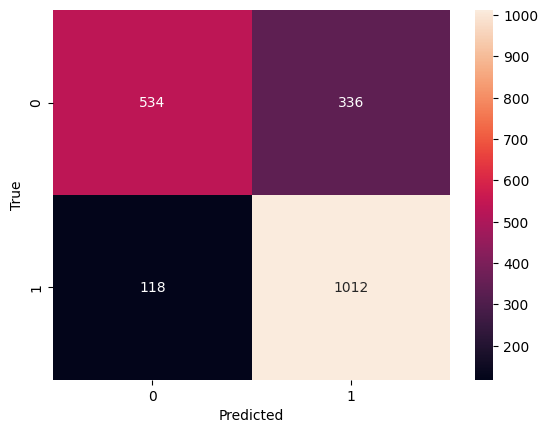

In [11]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Plot Feature Count vs Accuracy

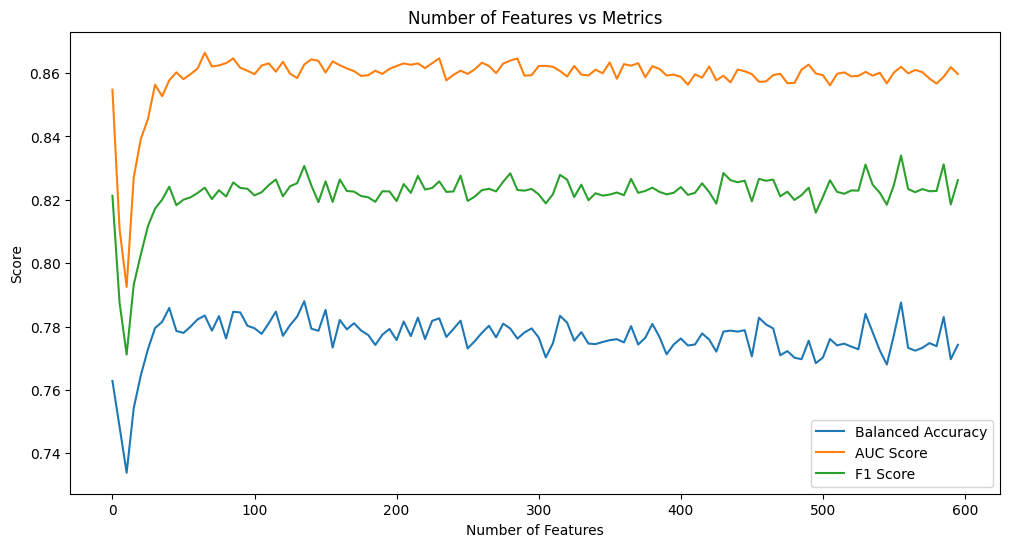

In [16]:
### ROC Pred Proba

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_

# Initialize lists to store metrics
balanced_accuracies = []
auc_scores = []
f1_scores = []

# Initialize list to store feature counts
feature_counts = []

# Sort feature importances
sorted_indices = np.argsort(importances)

for num_features in range(0, 600, 5):
    # Get top features
    top_features = [features[i] for i in sorted_indices[-num_features:]]

    # Select the features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Train Random Forest Classifier
    clf = RandomForestClassifier()
    clf.fit(X_train_selected, y_train)

    # Evaluate the model using balanced accuracy
    y_pred = clf.predict(X_test_selected)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Evaluate the model using F1 score
    f1 = f1_score(y_test, y_pred)

    # Evaluate the model using AUC-ROC with predict_proba
    y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Store the metrics and feature count
    balanced_accuracies.append(balanced_accuracy)
    auc_scores.append(auc_score)
    f1_scores.append(f1)
    feature_counts.append(num_features)

# Create the plot
plt.figure(figsize=(12, 6))

# Plotting Balanced Accuracy
plt.plot(feature_counts, balanced_accuracies, label='Balanced Accuracy')

# Plotting AUC Score
plt.plot(feature_counts, auc_scores, label='AUC Score')

# Plotting F1 Score
plt.plot(feature_counts, f1_scores, label='F1 Score')

plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Number of Features vs Metrics')
plt.legend()

plt.show()

The graph titled "Number of Features vs Metrics" illustrates the performance of three different metrics - Balanced Accuracy, AUC Score, and F1 Score - as the number of features increases. At a glance, we can observe a significant peak for all three metrics when the number of features is around 80. The Balanced Accuracy, AUC Score, and F1 Score all demonstrate an elevation in their scores at this point. As the number of features continues to increase beyond 80, the scores either stabilize or show a slight decline, indicating diminishing returns in performance improvement.

Given this analysis, choosing 80 features seems to be an optimal decision, as it represents a point where all three evaluation metrics converge at a high score. This suggests that increasing the features beyond this point might not contribute significantly to the improvement of the model's performance and may even lead to overfitting or increased computational costs.

### Select Top 80 Features According to Random Forest Results

In [12]:
all_features_df = pd.read_csv('all_features_df.csv')

In [13]:
# Get the indices of the top features
sorted_indices = np.argsort(importances)[-80:]

# Create a list of the top features
top_80_features = []
for i in sorted_indices:
    top_80_features.append(features[i])

# Create a list of the top features and the column name 'uti'
features_to_select = top_80_features + ['uti']

# Select the features from the all_features_df dataframe
selected_features_80 = all_features_df[features_to_select]

# Print the shape of the selected_features_df dataframe
selected_features_80.shape

(58976, 81)

In [14]:
# Save the Random Forest Selected Top Features for Model Training
selected_features_80.to_csv('selected_features_80.csv', index=False)

In [15]:
# Download the file to local system
from google.colab import files
files.download('selected_features_80.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>